In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, normalize #para normalizar los valores
from copy import deepcopy

In [4]:
def ObtenerMetricas(metrica, metricas_values, metricas_ranking, metricas_sorted, dominios):
    for g in range(len(dominios)):
        graph_pagerank = metrica(dominios[g])
        
        nombre = 'nacional' if g==0 else f'dom_{g-1}'
        metricas_values[nombre] = [graph_pagerank[pr] if pr in dominios[g].nodes else np.nan for pr in df.columns]

        metricas_ranking[nombre] = np.nan
        for i,tupla in enumerate(sorted(graph_pagerank.items(), key=lambda x: x[1], reverse=True)):
            metricas_ranking.loc[tupla[0],nombre] = i+1

        sorteado = [k for k,v in sorted(graph_pagerank.items(), key=lambda x: x[1], reverse=True)]
        sorteado.extend([np.nan]*(40-len(sorteado)))
        metricas_sorted[nombre] = sorteado

    return 

In [5]:
def obtenerMayorAristaPorNodo(G_org, orden):
    G = deepcopy(G_org)
    
    for node in G.nodes():
        edges = G.edges(node, data=True)
        if len(edges) > 1:  # some nodes have zero edges going into it
            max_weight = max([edge[2]['weight'] for edge in edges])

            for edge in list(edges):
                if edge[2]['weight'] < max_weight:
                    G.remove_edge(edge[0], edge[1])
                    
    return [(orden-a+1,ii[0],ii[1],ii[2]['weight']) for a,ii in enumerate(sorted(G.edges(data=True), key=lambda edge: edge[2].get('weight', 1)))][::-1]

In [6]:
def find_components(graph):
    n_components, labels = connected_components(csgraph=csr_matrix(nx.adjacency_matrix(graph)), 
                                                directed=True, 
                                                connection='strong', 
                                                return_labels=True)
    nodes = list(graph.nodes)
    
    print(f'Hay {n_components} componentes fuertemente conexos en el grafo.\n')
    #for violencia in ['P10_8_abuso', 'P10_8_atencion']:
    violencia = 'P10_8_abuso'
    componente = []
    c = labels[nodes.index(violencia)]

    for i in range(len(labels)):
        if labels[i]==c:
            componente.append(nodes[i])

    print(f'El componente al que corresponde {violencia} es {c} con {len(componente)} elementos.')
    print(componente, '\n')
    
    return componente

In [7]:
def GraficarRed(red, positions, metricas_sorted, localidad, axs, graph_by_ranking, 
                nombres_nodos=None, metrica='centralidad', cmap=plt.cm.Blues):
    if graph_by_ranking:
        node_color = [metricas_sorted[metricas_sorted[localidad]==col].index[0] for col in red.nodes]
    else: # no funciona por alguna razon
        node_color = [v for k,v in red.nodes(data='centralidad')] if metrica=='centralidad' else [v for k,v in red.nodes(data='pagerank')]
    
    nx.draw_networkx_nodes(red, positions, node_size=600, cmap=cmap,
                           node_color=node_color, 
                           ax=axs)
    nx.draw_networkx_labels(red, positions, font_size=45, ax=axs, labels=nombres_nodos)
    nx.draw_networkx_edges(red, positions, edgelist=red.edges(data='weight'), width=3,
                           node_size=600,
                           edge_color=[plt.cm.Greys(e[2]) for e in red.edges(data='weight')], 
                           ax=axs)
    

In [8]:
def GraficarGrafo(grafo_org, metricas_sorted, metrica, pos, localidad, fname=None, cmap=plt.cm.Blues, 
                  graph_by_ranking = True, nombres_nodos=None, 
                  n_rows=None, nodes_graf=None, nodes_No_graf=None,
                  graph_colorbar=True):
    red = deepcopy(grafo_org)

    fig, axs = plt.subplots(1, figsize=(30, 15))
    
    nombres_nodos_graf = {k:nombres_nodos[k] for k in metricas_sorted[localidad].dropna()}
    GraficarRed(red, positions=pos, metricas_sorted=metricas_sorted, localidad=localidad, 
                nombres_nodos=nombres_nodos_graf, metrica=metrica, axs=axs, 
                graph_by_ranking=graph_by_ranking, cmap=cmap)
    
    if graph_colorbar:
        fig.subplots_adjust(bottom=0.01, top=1, left=0, right=1.09)
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), orientation='vertical', 
                            ax=axs, shrink=0.85, ticks=[0, 0.5, 1])
        cbar.set_ticklabels(['bajo', 'medio', 'alto'])
        cbar.ax.tick_params(labelsize=30) 

    plt.tight_layout()
    
    if fname != None:
        plt.savefig(fname, pad_inches=0)
    plt.show()
    return

In [9]:
dominio_encoder = {0:'Semi urbano', 1:'Rural', 2:'Urbano'}

## Cargar datos

In [10]:
df = pd.read_csv('data/pesos_nac.csv', na_values=[np.nan], index_col='Unnamed: 0').abs().fillna(0)

In [11]:
df.shape

(43, 43)

In [12]:
pesos_dominios = []
for i in range(3):
    pesos_dominios.append(pd.read_csv(f'data/pesos_dom_{i}.csv', na_values=[np.nan], index_col='Unnamed: 0').abs().fillna(0))

In [13]:
pesos_dominios[0].shape

(42, 42)

## Crear grafos

Nacional

In [14]:
G_2 = nx.empty_graph(0, nx.MultiDiGraph()) #initialize an empty weighted directed graph

df2 = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.columns)
df2[df2==0] = np.nan

for row in df.index:
    for col in df.columns:
        if not np.isnan(df2.loc[row, col]):
            G_2.add_edge(col, row, weight=df2.loc[row, col])

Dominio

In [15]:
dominio = [nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph())]

for i in range(3):
    pesos = pd.DataFrame(MinMaxScaler().fit_transform(pesos_dominios[i]), columns=pesos_dominios[i].columns, index=pesos_dominios[i].index)
    pesos[pesos==0] = np.nan
    
    for row in pesos_dominios[i].index:
        for col in pesos_dominios[i].columns:
            if not np.isnan(pesos.loc[row, col]):
                dominio[i].add_edge(col, row, weight=pesos.loc[row, col])

### Visualizar

In [16]:
8.5*.9

7.65

In [17]:
dominio_encoder

{0: 'Semi urbano', 1: 'Rural', 2: 'Urbano'}

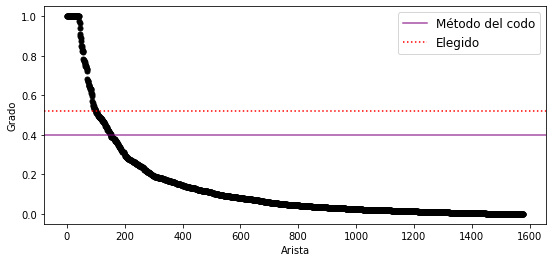

In [18]:
fig, axs = plt.subplots(figsize=(9, 4))
g = -1
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs.plot(grados[::-1], '.k', markersize=10)
axs.set(xlabel='Arista', ylabel='Grado')
axs.axhline(y=0.4, color='purple', linestyle='-', alpha=.7, label='Método del codo')
axs.axhline(y=0.52, color='r', linestyle='dotted', label='Elegido')

plt.legend(fontsize='large')
plt.savefig('graficas/codo_nac.png', pad_inches=0)
plt.show()

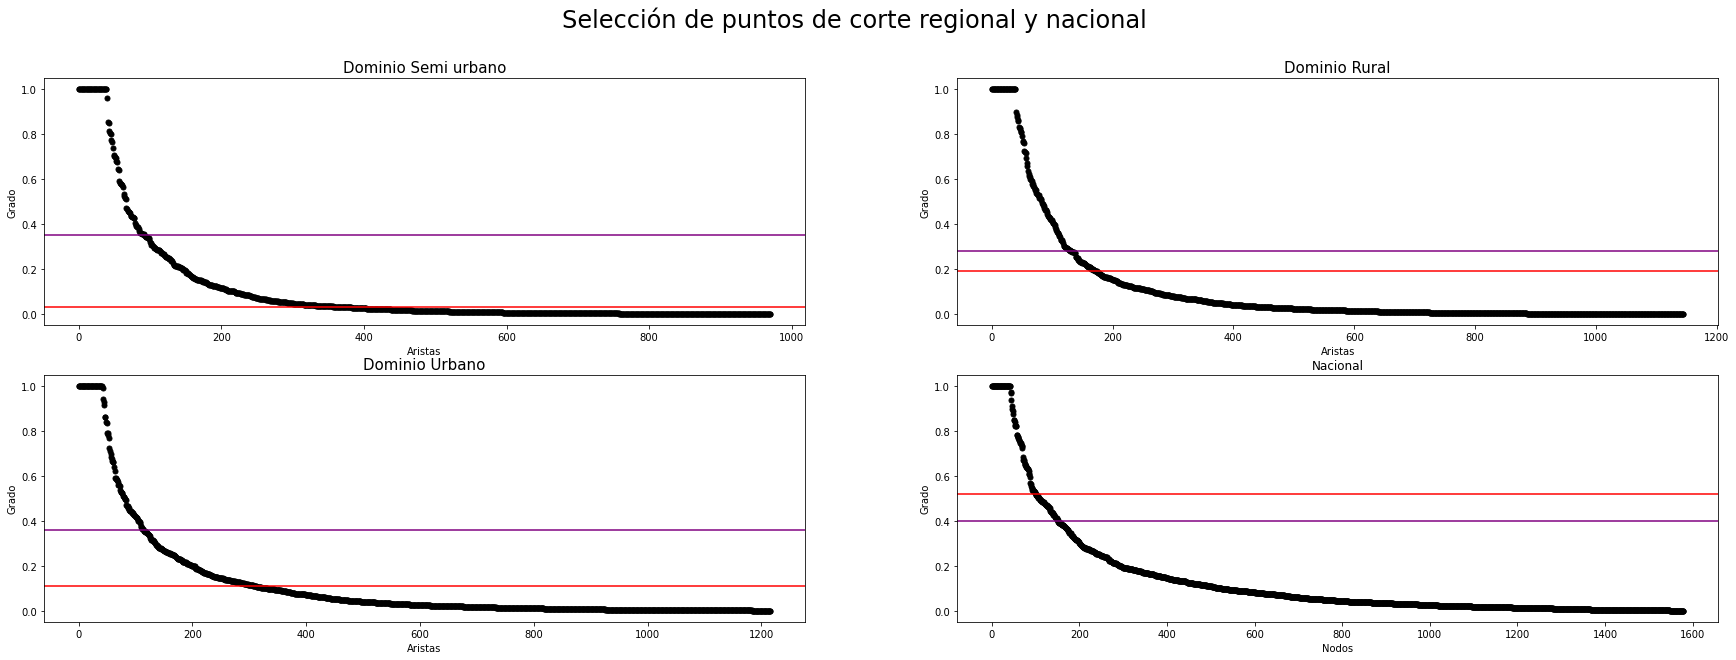

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

for g in range(3):
    grados = sorted([i[2] for i in dominio[g].edges(data='weight')])
    axs[g//2, g%2].plot(grados[::-1], '.k', markersize=10)
    axs[g//2, g%2].set_title(f'Dominio {dominio_encoder[g]}', fontsize=15)
    axs[g//2, g%2].set(xlabel='Aristas', ylabel='Grado')
    axs[g//2, g%2].axhline(y=[0.35,0.28,0.36][g], color='purple', linestyle='-')
    axs[g//2, g%2].axhline(y=[0.03,0.19,0.11][g], color='r', linestyle='-')
    

###NACIONAL###
#grafico el peso de las aristas
g = -1
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs[1, 1].plot(grados[::-1], '.k', markersize=10)
axs[1, 1].set_title(f'Nacional')
axs[1, 1].set(xlabel='Nodos', ylabel='Grado')
axs[1, 1].axhline(y=0.52, color='r', linestyle='-')
axs[1, 1].axhline(y=0.4, color='purple', linestyle='-')

fig.suptitle('Selección de puntos de corte regional y nacional', fontsize=24)
plt.show()

## Eliminar aristas

In [20]:
#para su uso en la visualización, necesito todos los nodos así que lo obtengo antes de borrar

positions = nx.circular_layout(G_2)

In [21]:
le_ids = list(e[:2] for e in filter(lambda e: e[2] < 0.4, (e for e in G_2.edges.data('weight')))) #codo en 0.52
G_2.remove_edges_from(le_ids)
print(f'La cantidad de aristas que hay son {G_2.number_of_edges()}\n')
componente_nacional = find_components(G_2) #nacional
nodos_remover = [c for c in df2.columns if c not in componente_nacional]
print(f'Los nodos que no están dentro de esta componente son:\n{nodos_remover}')
G_2.remove_nodes_from(nodos_remover)

La cantidad de aristas que hay son 152

Hay 15 componentes fuertemente conexos en el grafo.

El componente al que corresponde P10_8_abuso es 0 con 25 elementos.
['DOMINIO', 'CVE_ENT', 'SITUACION_CONYUGAL', 'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 'FOCOS', 'DRENAJE', 'NUM_RESIDENTES', 'BIENES_DE_VIVIENDA', 'PAREN', 'EDAD', 'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRADO_ESCOLAR', 'VERIF_SITUACION_PAREJA', 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS', 'PAREJA_GANANCIAS_FRECUENCIA', 'PAREJA_APORTA_PARA_GASTO', 'PAREJA_CUANTO_APORTA_GASTO', 'PROPIEDADES_DEL_HOGAR', 'MES_PARTO', 'P10_8_abuso', 'P10_8_atencion'] 

Los nodos que no están dentro de esta componente son:
['MATERIAL_PISOS', 'AGUA', 'NUM_HOGARES', 'ALFABETISMO', 'ASISTENCIA_ESC', 'PERT_INDIGENA', 'LENG_INDIGENA', 'ENTREVISTADA_TRABAJA', 'LIBERTAD_USAR_DINERO', 'FUENTES_DE_DINERO', 'NUM_EMBARAZOS', 'NACIO_VIV', 'NACIO_MUERT', 'ABORTO', 'ANIO_PARTO', 'DONDE_ATENDIO_PARTO', 'SERVICIOS_MEDICOS_AFILIADA', 'DONDE_CONSULTAS_PRENATALES']


In [22]:
le_ids = list(e[:2] for e in filter(lambda e: e[2] < 0.03, (e for e in dominio[0].edges.data('weight')))) #codo en 0.35
dominio[0].remove_edges_from(le_ids)
print(f'La cantidad de aristas que hay son {dominio[0].number_of_edges()}\n')
componente_semi = find_components(dominio[0]) #semiurbano
nodos_remover = [c for c in df2.columns if c not in componente_semi]
print(f'Los nodos que no están dentro de esta componente son:\n{nodos_remover}')
dominio[0].remove_nodes_from(nodos_remover)

La cantidad de aristas que hay son 382

Hay 4 componentes fuertemente conexos en el grafo.

El componente al que corresponde P10_8_abuso es 2 con 39 elementos.
['SITUACION_CONYUGAL', 'CVE_ENT', 'MATERIAL_PISOS', 'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 'AGUA', 'DRENAJE', 'NUM_RESIDENTES', 'NUM_HOGARES', 'BIENES_DE_VIVIENDA', 'PAREN', 'EDAD', 'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRADO_ESCOLAR', 'ASISTENCIA_ESC', 'PERT_INDIGENA', 'LENG_INDIGENA', 'VERIF_SITUACION_PAREJA', 'ENTREVISTADA_TRABAJA', 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS_FRECUENCIA', 'PAREJA_APORTA_PARA_GASTO', 'PAREJA_CUANTO_APORTA_GASTO', 'LIBERTAD_USAR_DINERO', 'FUENTES_DE_DINERO', 'PROPIEDADES_DEL_HOGAR', 'NUM_EMBARAZOS', 'NACIO_VIV', 'NACIO_MUERT', 'ABORTO', 'ANIO_PARTO', 'MES_PARTO', 'DONDE_ATENDIO_PARTO', 'P10_8_abuso', 'P10_8_atencion', 'SERVICIOS_MEDICOS_AFILIADA', 'DONDE_CONSULTAS_PRENATALES'] 

Los nodos que no están dentro de esta componente son:
['DOMINIO', 'FOCOS', 'ALFABETISMO', 'PAREJA_GANANCIAS']


In [23]:
le_ids = list(e[:2] for e in filter(lambda e: e[2] < 0.19, (e for e in dominio[1].edges.data('weight')))) #codo en 0.28
dominio[1].remove_edges_from(le_ids)
print(f'La cantidad de aristas que hay son {dominio[1].number_of_edges()}\n')
componente_rural = find_components(dominio[1]) #rural
nodos_remover = [c for c in df2.columns if c not in componente_rural]
print(f'Los nodos que no están dentro de esta componente son:\n{nodos_remover}')
dominio[1].remove_nodes_from(nodos_remover)

La cantidad de aristas que hay son 175

Hay 10 componentes fuertemente conexos en el grafo.

El componente al que corresponde P10_8_abuso es 3 con 30 elementos.
['SITUACION_CONYUGAL', 'CVE_ENT', 'MATERIAL_PISOS', 'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 'AGUA', 'DRENAJE', 'NUM_RESIDENTES', 'BIENES_DE_VIVIENDA', 'PAREN', 'EDAD', 'RES_MADRE', 'RES_PADRE', 'PERT_INDIGENA', 'LENG_INDIGENA', 'VERIF_SITUACION_PAREJA', 'ENTREVISTADA_TRABAJA', 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS', 'PAREJA_GANANCIAS_FRECUENCIA', 'PAREJA_APORTA_PARA_GASTO', 'LIBERTAD_USAR_DINERO', 'PROPIEDADES_DEL_HOGAR', 'ANIO_PARTO', 'MES_PARTO', 'DONDE_ATENDIO_PARTO', 'P10_8_abuso', 'P10_8_atencion', 'SERVICIOS_MEDICOS_AFILIADA', 'DONDE_CONSULTAS_PRENATALES'] 

Los nodos que no están dentro de esta componente son:
['DOMINIO', 'FOCOS', 'NUM_HOGARES', 'ESCOLARIDAD', 'GRADO_ESCOLAR', 'ALFABETISMO', 'ASISTENCIA_ESC', 'PAREJA_CUANTO_APORTA_GASTO', 'FUENTES_DE_DINERO', 'NUM_EMBARAZOS', 'NACIO_VIV', 'NACIO_MUERT', 'ABORTO']


In [24]:
le_ids = list(e[:2] for e in filter(lambda e: e[2] < 0.1, (e for e in dominio[2].edges.data('weight')))) #codo en 0.36
dominio[2].remove_edges_from(le_ids)
print(f'La cantidad de aristas que hay son {dominio[2].number_of_edges()}\n')
componente_urbano = find_components(dominio[2]) #urbano
nodos_remover = [c for c in df2.columns if c not in componente_urbano]
print(f'Los nodos que no están dentro de esta componente son:\n{nodos_remover}')
dominio[2].remove_nodes_from(nodos_remover)

La cantidad de aristas que hay son 329

Hay 4 componentes fuertemente conexos en el grafo.

El componente al que corresponde P10_8_abuso es 0 con 39 elementos.
['SITUACION_CONYUGAL', 'CVE_ENT', 'MATERIAL_PISOS', 'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 'FOCOS', 'AGUA', 'DRENAJE', 'NUM_RESIDENTES', 'NUM_HOGARES', 'BIENES_DE_VIVIENDA', 'PAREN', 'EDAD', 'RES_MADRE', 'RES_PADRE', 'ESCOLARIDAD', 'GRADO_ESCOLAR', 'PERT_INDIGENA', 'LENG_INDIGENA', 'VERIF_SITUACION_PAREJA', 'ENTREVISTADA_TRABAJA', 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS', 'PAREJA_GANANCIAS_FRECUENCIA', 'PAREJA_APORTA_PARA_GASTO', 'PAREJA_CUANTO_APORTA_GASTO', 'LIBERTAD_USAR_DINERO', 'FUENTES_DE_DINERO', 'PROPIEDADES_DEL_HOGAR', 'NUM_EMBARAZOS', 'NACIO_VIV', 'ABORTO', 'ANIO_PARTO', 'MES_PARTO', 'DONDE_ATENDIO_PARTO', 'P10_8_abuso', 'P10_8_atencion', 'SERVICIOS_MEDICOS_AFILIADA', 'DONDE_CONSULTAS_PRENATALES'] 

Los nodos que no están dentro de esta componente son:
['DOMINIO', 'ALFABETISMO', 'ASISTENCIA_ESC', 'NACIO_MUERT']


# Arista más pesada por nodo

In [25]:
#rural
maximos_rural = obtenerMayorAristaPorNodo(dominio[1], orden=30)
maximos_rural

[(2, 'DONDE_CONSULTAS_PRENATALES', 'DONDE_ATENDIO_PARTO', 1.0),
 (3, 'SERVICIOS_MEDICOS_AFILIADA', 'CVE_ENT', 1.0),
 (4, 'P10_8_abuso', 'CVE_ENT', 1.0),
 (5, 'DONDE_ATENDIO_PARTO', 'DONDE_CONSULTAS_PRENATALES', 1.0),
 (6, 'ANIO_PARTO', 'CVE_ENT', 1.0),
 (7, 'PAREJA_GANANCIAS_FRECUENCIA', 'PAREJA_GANANCIAS', 1.0),
 (8, 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS', 1.0),
 (9, 'ENTREVISTADA_TRABAJA', 'CVE_ENT', 1.0),
 (10, 'VERIF_SITUACION_PAREJA', 'CVE_ENT', 1.0),
 (11, 'RES_PADRE', 'PAREN', 1.0),
 (12, 'RES_MADRE', 'PAREN', 1.0),
 (13, 'EDAD', 'CVE_ENT', 1.0),
 (14, 'PAREN', 'SITUACION_CONYUGAL', 1.0),
 (15, 'BIENES_DE_VIVIENDA', 'CVE_ENT', 1.0),
 (16, 'NUM_RESIDENTES', 'CVE_ENT', 1.0),
 (17, 'DRENAJE', 'CVE_ENT', 1.0),
 (18, 'AGUA', 'CVE_ENT', 1.0),
 (19, 'CUARTOS_TOTAL', 'CUARTOS_DORMIR', 1.0),
 (20, 'CUARTOS_DORMIR', 'CUARTOS_TOTAL', 1.0),
 (21, 'MATERIAL_PISOS', 'CVE_ENT', 1.0),
 (22, 'CVE_ENT', 'DRENAJE', 1.0),
 (23, 'SITUACION_CONYUGAL', 'PAREJA_GANANCIAS', 1.0),
 (24, 'P10_8_atencion', '

In [26]:
#urbano
maximos_urbano = obtenerMayorAristaPorNodo(dominio[2], orden=39)
maximos_urbano

[(2, 'SERVICIOS_MEDICOS_AFILIADA', 'CVE_ENT', 1.0),
 (3, 'P10_8_atencion', 'CVE_ENT', 1.0),
 (4, 'P10_8_abuso', 'CVE_ENT', 1.0),
 (5, 'DONDE_ATENDIO_PARTO', 'DONDE_CONSULTAS_PRENATALES', 1.0),
 (6, 'MES_PARTO', 'CVE_ENT', 1.0),
 (7, 'ANIO_PARTO', 'CVE_ENT', 1.0),
 (8, 'ABORTO', 'NUM_EMBARAZOS', 1.0),
 (9, 'NACIO_VIV', 'NUM_EMBARAZOS', 1.0),
 (10, 'NUM_EMBARAZOS', 'NACIO_VIV', 1.0),
 (11, 'FUENTES_DE_DINERO', 'CVE_ENT', 1.0),
 (12, 'LIBERTAD_USAR_DINERO', 'CVE_ENT', 1.0),
 (13, 'PAREJA_CUANTO_APORTA_GASTO', 'PAREJA_GANANCIAS', 1.0),
 (14, 'PAREJA_APORTA_PARA_GASTO', 'PAREJA_CUANTO_APORTA_GASTO', 1.0),
 (15, 'PAREJA_GANANCIAS', 'CVE_ENT', 1.0),
 (16, 'PAREJA_TRABAJA', 'PAREJA_GANANCIAS', 1.0),
 (17, 'ENTREVISTADA_TRABAJA', 'PAREJA_GANANCIAS', 1.0),
 (18, 'VERIF_SITUACION_PAREJA', 'CVE_ENT', 1.0),
 (19, 'LENG_INDIGENA', 'PERT_INDIGENA', 1.0),
 (20, 'GRADO_ESCOLAR', 'ESCOLARIDAD', 1.0),
 (21, 'RES_PADRE', 'PAREN', 1.0),
 (22, 'RES_MADRE', 'PAREN', 1.0),
 (23, 'EDAD', 'CVE_ENT', 1.0),
 (24,

# Metricas

## Pagerank

In [27]:
pagerank_values = pd.DataFrame(index=df.columns)
pagerank_ranking = pd.DataFrame(index=df.columns)
pagerank_sorted = pd.DataFrame(index=range(40))

In [28]:
ObtenerMetricas(nx.pagerank_numpy, pagerank_values, pagerank_ranking, pagerank_sorted, [G_2,dominio[0],dominio[1],dominio[2]])

#pagerank_values[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/pagerank_values.csv')
#pagerank_ranking[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/pagerank_ranking.csv')
#pagerank_sorted[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/pagerank_sorted.csv', index=False)

In [29]:
pagerank_sorted.head(10)

,nacional,dom_0,dom_1,dom_2
0,CVE_ENT,CVE_ENT,CVE_ENT,CVE_ENT
1,PAREJA_GANANCIAS,MES_PARTO,MES_PARTO,PAREJA_GANANCIAS
2,CUARTOS_DORMIR,DRENAJE,DRENAJE,MES_PARTO
3,MES_PARTO,NACIO_VIV,PAREJA_GANANCIAS,BIENES_DE_VIVIENDA
4,DOMINIO,AGUA,PERT_INDIGENA,FOCOS
5,PAREJA_CUANTO_APORTA_GASTO,PAREJA_CUANTO_APORTA_GASTO,CUARTOS_DORMIR,PROPIEDADES_DEL_HOGAR
6,DRENAJE,NUM_EMBARAZOS,AGUA,ANIO_PARTO
7,CUARTOS_TOTAL,BIENES_DE_VIVIENDA,VERIF_SITUACION_PAREJA,PAREJA_CUANTO_APORTA_GASTO
8,PAREN,DONDE_CONSULTAS_PRENATALES,BIENES_DE_VIVIENDA,DRENAJE
9,NUM_RESIDENTES,VERIF_SITUACION_PAREJA,DONDE_CONSULTAS_PRENATALES,PAREN


## Centralidad de grado

In [30]:
degree_centrality_values = pd.DataFrame(index=df.columns)
degree_centrality_ranking = pd.DataFrame(index=df.columns)
degree_centrality_sorted = pd.DataFrame(index=range(40))

In [31]:
ObtenerMetricas(nx.in_degree_centrality, degree_centrality_values, 
                degree_centrality_ranking, degree_centrality_sorted, [G_2,dominio[0],dominio[1],dominio[2]])
    
#degree_centrality_values[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/degree_centrality_values.csv')
#degree_centrality_ranking[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/degree_centrality_ranking.csv')
#degree_centrality_sorted[['dom_1','dom_2']].rename(columns={'dom_1':'rural','dom_2':'urbano'}).to_csv(f'data/degree_centrality_sorted.csv', index=False)

In [32]:
degree_centrality_sorted.head(10)

,nacional,dom_0,dom_1,dom_2
0,CVE_ENT,CVE_ENT,CVE_ENT,CVE_ENT
1,PAREJA_GANANCIAS,MES_PARTO,MES_PARTO,MES_PARTO
2,MES_PARTO,PAREJA_CUANTO_APORTA_GASTO,BIENES_DE_VIVIENDA,PAREJA_GANANCIAS
3,PAREJA_CUANTO_APORTA_GASTO,BIENES_DE_VIVIENDA,PAREJA_GANANCIAS,FOCOS
4,PAREN,EDAD,PAREN,BIENES_DE_VIVIENDA
5,CUARTOS_DORMIR,NUM_RESIDENTES,EDAD,NUM_RESIDENTES
6,FOCOS,ANIO_PARTO,SITUACION_CONYUGAL,PAREJA_CUANTO_APORTA_GASTO
7,NUM_RESIDENTES,ESCOLARIDAD,NUM_RESIDENTES,ESCOLARIDAD
8,EDAD,PAREN,CUARTOS_DORMIR,EDAD
9,DOMINIO,CUARTOS_TOTAL,AGUA,ANIO_PARTO


In [33]:
dc_ = pd.DataFrame(index=df.columns)
dc_sorted = pd.DataFrame(index=range(40))
ObtenerMetricas(nx.out_degree_centrality, dc_, dc_, dc_sorted, [G_2,dominio[0],dominio[1],dominio[2]])
dc_sorted.head(20)

,nacional,dom_0,dom_1,dom_2
0,CUARTOS_TOTAL,SITUACION_CONYUGAL,CVE_ENT,PERT_INDIGENA
1,NUM_RESIDENTES,CVE_ENT,PAREN,PAREN
2,EDAD,PAREN,ENTREVISTADA_TRABAJA,CVE_ENT
3,PROPIEDADES_DEL_HOGAR,ASISTENCIA_ESC,LIBERTAD_USAR_DINERO,ENTREVISTADA_TRABAJA
4,CVE_ENT,SERVICIOS_MEDICOS_AFILIADA,P10_8_abuso,SERVICIOS_MEDICOS_AFILIADA
5,BIENES_DE_VIVIENDA,ENTREVISTADA_TRABAJA,SERVICIOS_MEDICOS_AFILIADA,PROPIEDADES_DEL_HOGAR
6,VERIF_SITUACION_PAREJA,NACIO_MUERT,SITUACION_CONYUGAL,NUM_RESIDENTES
7,DOMINIO,CUARTOS_DORMIR,NUM_RESIDENTES,MATERIAL_PISOS
8,SITUACION_CONYUGAL,LIBERTAD_USAR_DINERO,AGUA,MES_PARTO
9,PAREN,P10_8_abuso,EDAD,EDAD


## Agregar las metricas como atributos a las aristas.

Agrego las metricas de centralidad y pagerank como atributos de los nodos.

In [34]:
columnas = pagerank_ranking.columns
for i in range(3):
    nx.set_node_attributes(dominio[i], pagerank_values[columnas[i+1]].to_dict(), name="pagerank")
    nx.set_node_attributes(dominio[i], degree_centrality_values[columnas[i+1]].to_dict(), name="centralidad")


In [35]:
nx.set_node_attributes(G_2, pagerank_values.nacional.to_dict(), name="pagerank")
nx.set_node_attributes(G_2, degree_centrality_values.nacional.to_dict(), name="centralidad")

Agregar los nodos como atributos a las aristas.

In [36]:
for dom in range(3):
    attrs = {}
    for i in dominio[dom].edges(data='weight', keys=True):
        attrs[(i[0],i[1], i[2])] = f'{round(i[3], 4)}, {i[0]}->{i[1]}'
        #                                  valor     nodo inicial -> nodo objetivo
    nx.set_edge_attributes(dominio[dom], attrs, 'PFI:')
    #                                PFI:  valor     nodo inicial -> nodo objetivo

In [37]:
attrs = {}
for i in G_2.edges(data='weight',keys=True):
    attrs[(i[0],i[1], i[2])] = f'{round(i[3], 4)}, {i[0]}->{i[1]}'
nx.set_edge_attributes(G_2, attrs, 'PFI:')

## Guardar las redes.

## Grafica nacional

In [38]:
nombres_nodos = {c:e for e,c in enumerate(degree_centrality_ranking.index.to_list())}

In [39]:
nombres_nodos

{'CVE_ENT': 0,
 'DOMINIO': 1,
 'SITUACION_CONYUGAL': 2,
 'MATERIAL_PISOS': 3,
 'CUARTOS_DORMIR': 4,
 'CUARTOS_TOTAL': 5,
 'FOCOS': 6,
 'AGUA': 7,
 'DRENAJE': 8,
 'NUM_RESIDENTES': 9,
 'NUM_HOGARES': 10,
 'BIENES_DE_VIVIENDA': 11,
 'PAREN': 12,
 'EDAD': 13,
 'RES_MADRE': 14,
 'RES_PADRE': 15,
 'ESCOLARIDAD': 16,
 'GRADO_ESCOLAR': 17,
 'ALFABETISMO': 18,
 'ASISTENCIA_ESC': 19,
 'PERT_INDIGENA': 20,
 'LENG_INDIGENA': 21,
 'VERIF_SITUACION_PAREJA': 22,
 'ENTREVISTADA_TRABAJA': 23,
 'PAREJA_TRABAJA': 24,
 'PAREJA_GANANCIAS': 25,
 'PAREJA_GANANCIAS_FRECUENCIA': 26,
 'PAREJA_APORTA_PARA_GASTO': 27,
 'PAREJA_CUANTO_APORTA_GASTO': 28,
 'LIBERTAD_USAR_DINERO': 29,
 'FUENTES_DE_DINERO': 30,
 'PROPIEDADES_DEL_HOGAR': 31,
 'NUM_EMBARAZOS': 32,
 'NACIO_VIV': 33,
 'NACIO_MUERT': 34,
 'ABORTO': 35,
 'ANIO_PARTO': 36,
 'MES_PARTO': 37,
 'DONDE_ATENDIO_PARTO': 38,
 'P10_8_abuso': 39,
 'P10_8_atencion': 40,
 'SERVICIOS_MEDICOS_AFILIADA': 41,
 'DONDE_CONSULTAS_PRENATALES': 42}

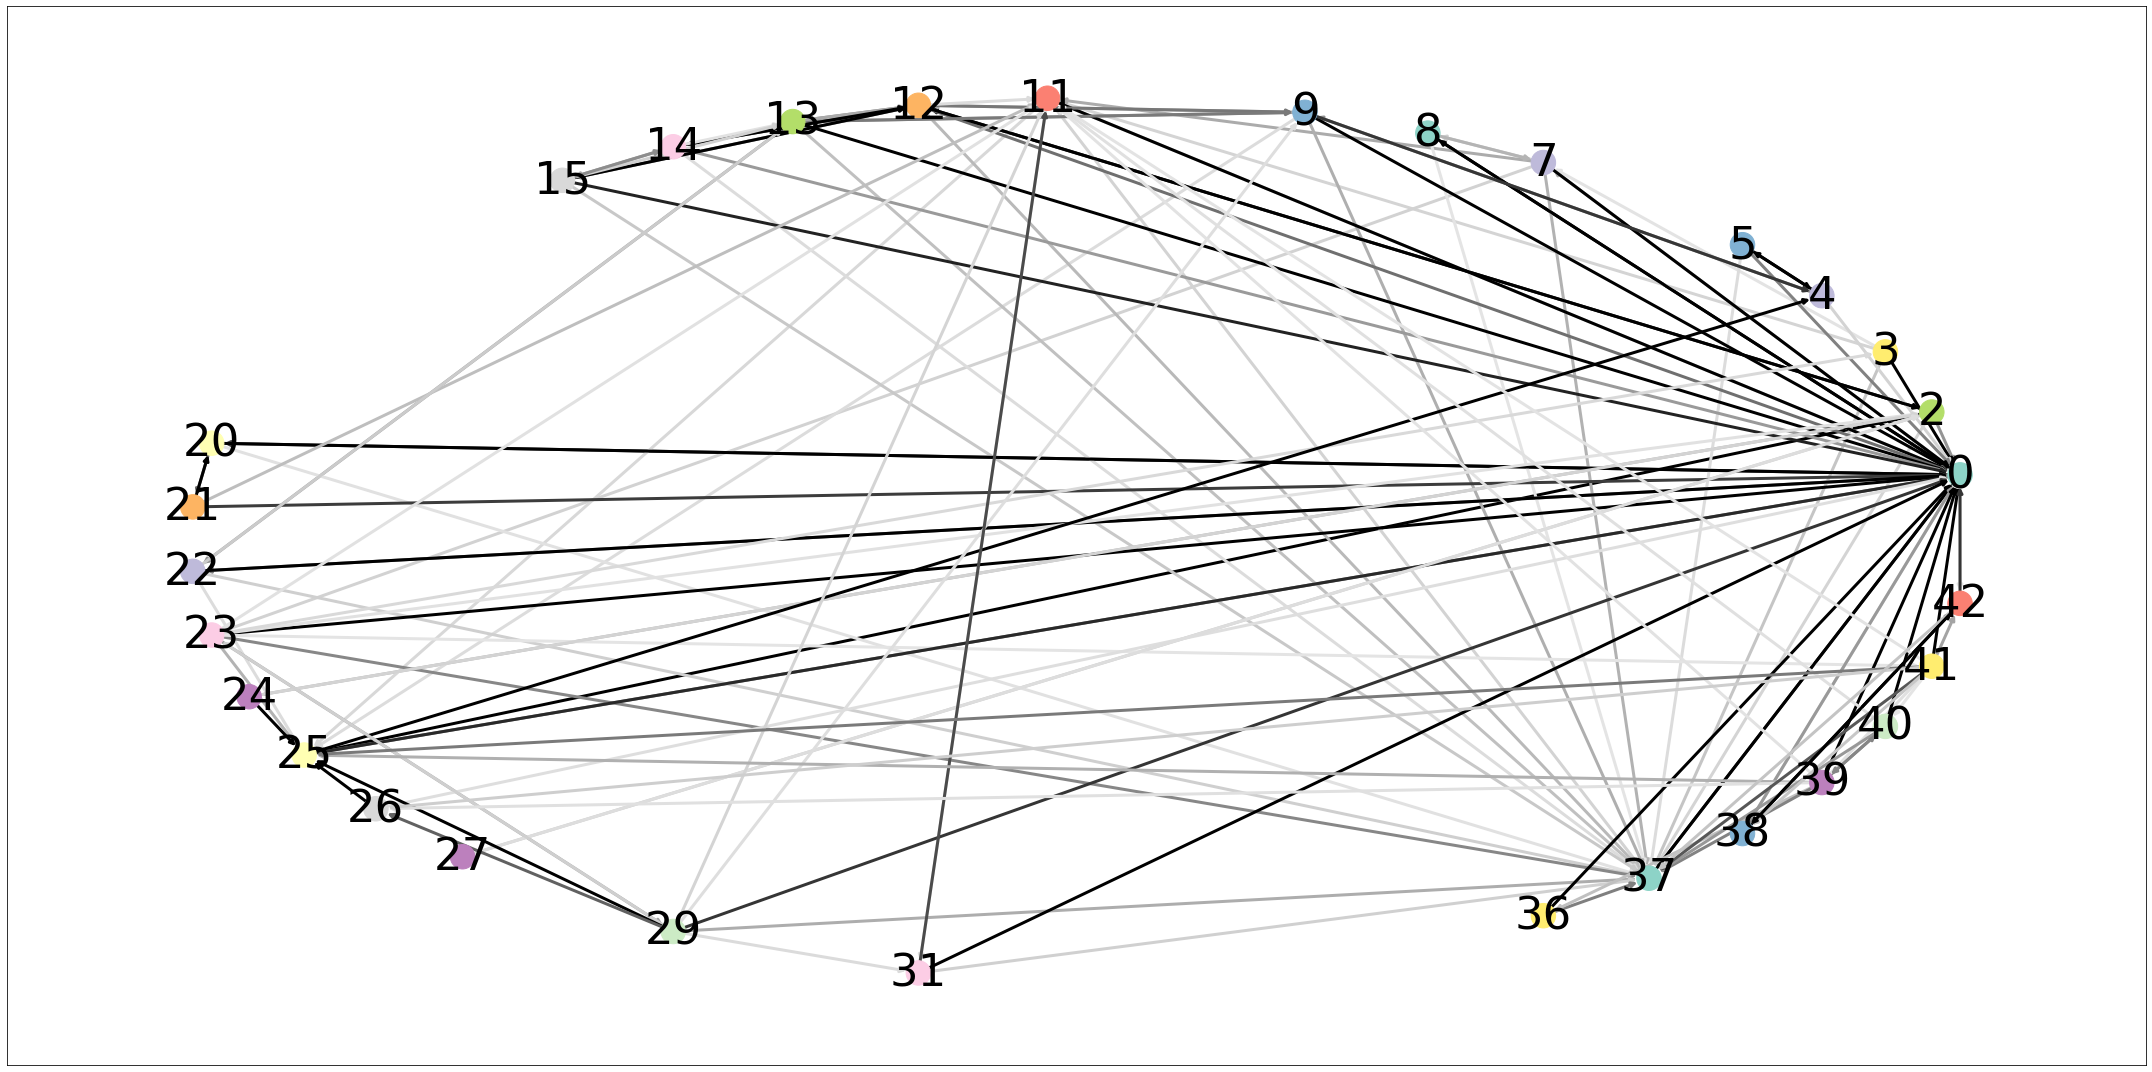

In [45]:
GraficarGrafo(dominio[1], pagerank_sorted, 
              metrica='pagerank',
              pos = positions,
              fname = 'graficas/rural.png',
              localidad = 'dom_1',
              graph_by_ranking = True,
              nombres_nodos=nombres_nodos,
              cmap = plt.cm.get_cmap('Set3'),
              graph_colorbar=False
             )

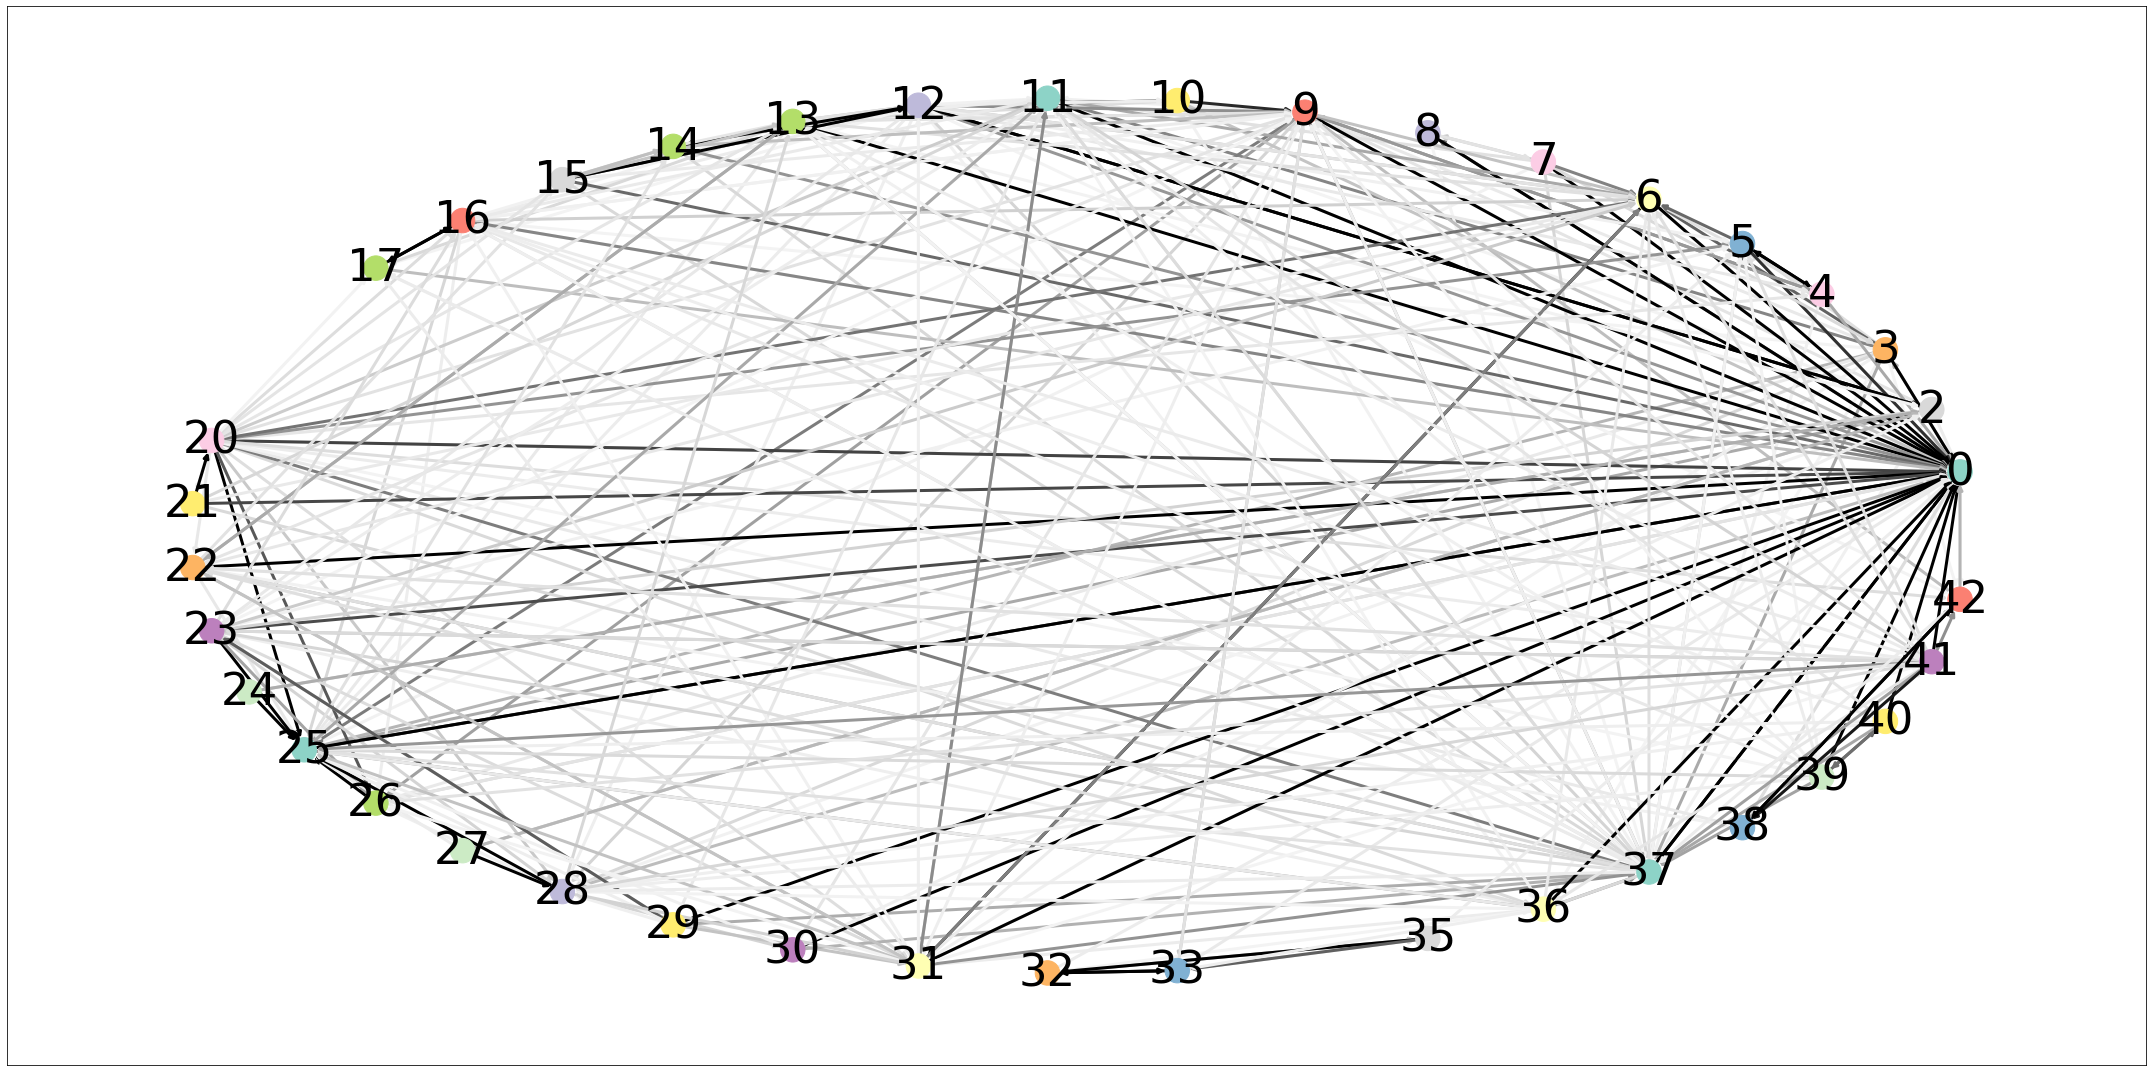

In [47]:
GraficarGrafo(dominio[2], pagerank_sorted, 
              metrica='pagerank',
              pos = positions,
              fname = 'graficas/urbano.png',
              localidad = 'dom_2',
              graph_by_ranking = True,
              nombres_nodos=nombres_nodos,
              cmap = plt.cm.get_cmap('Set3'),
              graph_colorbar=False
             )

# Clasificación de jerarquías

In [41]:
head_nodes_pr = pagerank_sorted.head(10).stack().unique()
head_nodes_dc = degree_centrality_sorted.head(10).stack().unique()
print(head_nodes_pr)
print(head_nodes_dc)

['CVE_ENT' 'PAREJA_GANANCIAS' 'MES_PARTO' 'CUARTOS_DORMIR' 'DRENAJE'
 'NACIO_VIV' 'BIENES_DE_VIVIENDA' 'DOMINIO' 'AGUA' 'PERT_INDIGENA' 'FOCOS'
 'PAREJA_CUANTO_APORTA_GASTO' 'PROPIEDADES_DEL_HOGAR' 'NUM_EMBARAZOS'
 'ANIO_PARTO' 'CUARTOS_TOTAL' 'VERIF_SITUACION_PAREJA' 'PAREN'
 'DONDE_CONSULTAS_PRENATALES' 'NUM_RESIDENTES']
['CVE_ENT' 'PAREJA_GANANCIAS' 'MES_PARTO' 'PAREJA_CUANTO_APORTA_GASTO'
 'BIENES_DE_VIVIENDA' 'FOCOS' 'PAREN' 'EDAD' 'CUARTOS_DORMIR'
 'NUM_RESIDENTES' 'ANIO_PARTO' 'SITUACION_CONYUGAL' 'ESCOLARIDAD'
 'DOMINIO' 'CUARTOS_TOTAL' 'AGUA']


In [42]:
def comparar_cambio_ranking_dominios(df_ranking, columnas):
    """
    df_ranking: el df de rankings
    columnas:   el nombre de las columnas del df de ranking a comparar, solo 2 o se reconocerán solo las primeras 2
    """
    fluctuacion_ranking = [df_ranking.loc[i,columnas[0]] - df_ranking.loc[i,columnas[1]] for i in df_ranking.index]
    return fluctuacion_ranking

def crear_df_comparacion_nacional_con_dominios(df_ranking, col_referencia):
    df = df = pd.DataFrame(index=df_ranking.index) # crear el nuevo df con las variables como indice
    dominios_a_comparar = list(df_ranking.columns)
    dominios_a_comparar.pop(dominios_a_comparar.index(col_referencia)) #eliminar col_referencia de la lista
    
    for dom in dominios_a_comparar: 
        df[dom] = comparar_cambio_ranking_dominios(df_ranking, [col_referencia,dom])
    return df

def obtener_tamanio_traslape(df_fluctuation):
    for col in df_fluctuation.columns:
        try:
            value = df_fluctuation[col].value_counts()[0]
        except:
            value = 0
        print(f'La cantidad de variables que se mantuvieron en el mismo lugar en {col} fueron {value}')

In [43]:
truncate_dc_ranking = degree_centrality_ranking[['dom_1','dom_2']].dropna(subset=['dom_1']).sort_values(by='dom_2')
truncate_dc_ranking['dom_2'] = range(1,len(degree_centrality_ranking['dom_1'].dropna())+1)

In [44]:
print('Centralidad de grado')
degree_centrality_fluctuation = crear_df_comparacion_nacional_con_dominios(truncate_dc_ranking[['dom_1','dom_2']], 'dom_1')
obtener_tamanio_traslape(degree_centrality_fluctuation)

Centralidad de grado
La cantidad de variables que se mantuvieron en el mismo lugar en dom_2 fueron 4


In [45]:
degree_centrality_fluctuation.columns = ['dif']
dc_fluct = truncate_dc_ranking[['dom_1','dom_2']].join(degree_centrality_fluctuation)
dc_fluct['diff_abs'] = dc_fluct['dif'].abs()
dc_fluct.columns = ['Rural','Urbano','Diferencia','diff_abs']
dc_fluct.sort_values(by='diff_abs', ascending=False)[['Rural','Urbano','Diferencia']]#.dropna()

,Rural,Urbano,Diferencia
ANIO_PARTO,29.0,7,22.0
CUARTOS_TOTAL,24.0,8,16.0
AGUA,10.0,21,-11.0
P10_8_atencion,21.0,30,-9.0
PROPIEDADES_DEL_HOGAR,20.0,11,9.0
DRENAJE,14.0,22,-8.0
CUARTOS_DORMIR,9.0,17,-8.0
SITUACION_CONYUGAL,7.0,14,-7.0
PERT_INDIGENA,17.0,23,-6.0
VERIF_SITUACION_PAREJA,18.0,12,6.0


In [46]:
truncate_pr_ranking = pagerank_ranking[['dom_1','dom_2']].dropna(subset=['dom_1']).sort_values(by='dom_2')
truncate_pr_ranking['dom_2'] = range(1,len(pagerank_ranking['dom_1'].dropna())+1)

In [47]:
print('Pagerank')
pagerank_fluctuation = crear_df_comparacion_nacional_con_dominios(truncate_pr_ranking[['dom_1','dom_2']], 'dom_1')
obtener_tamanio_traslape(pagerank_fluctuation)

Pagerank
La cantidad de variables que se mantuvieron en el mismo lugar en dom_2 fueron 2


In [48]:
pagerank_fluctuation.columns = ['dif']
pr_fluct = truncate_pr_ranking[['dom_1','dom_2']].join(pagerank_fluctuation)
pr_fluct['diff_abs'] = pr_fluct['dif'].abs()
pr_fluct.columns = ['Rural','Urbano','Diferencia','diff_abs']
pr_fluct.sort_values(by='diff_abs', ascending=False)[['Rural','Urbano','Diferencia']].round().abs()#.dropna()

,Rural,Urbano,Diferencia
ANIO_PARTO,30.0,6.0,24.0
LENG_INDIGENA,14.0,30.0,16.0
MATERIAL_PISOS,29.0,14.0,15.0
PERT_INDIGENA,5.0,20.0,15.0
PROPIEDADES_DEL_HOGAR,19.0,5.0,14.0
AGUA,7.0,19.0,12.0
CUARTOS_DORMIR,6.0,18.0,12.0
PAREJA_GANANCIAS_FRECUENCIA,22.0,15.0,7.0
PAREN,15.0,8.0,7.0
ENTREVISTADA_TRABAJA,18.0,24.0,6.0


In [49]:
print('Rural')
rural = degree_centrality_ranking[['dom_1']].copy()
rural['pr'] = pagerank_ranking[['dom_1']]
rural_fluctuation = crear_df_comparacion_nacional_con_dominios(rural, 'dom_1')
obtener_tamanio_traslape(rural_fluctuation)

Rural
La cantidad de variables que se mantuvieron en el mismo lugar en pr fueron 3


In [50]:
rural_fluctuation.columns = ['diff']
rural.join(rural_fluctuation.abs()).sort_values(by='diff', ascending=False)

,dom_1,pr,diff
CUARTOS_TOTAL,24.0,12.0,12.0
PERT_INDIGENA,17.0,5.0,12.0
LENG_INDIGENA,25.0,14.0,11.0
DRENAJE,14.0,3.0,11.0
PAREJA_GANANCIAS_FRECUENCIA,11.0,22.0,11.0
VERIF_SITUACION_PAREJA,18.0,8.0,10.0
PAREN,5.0,15.0,10.0
SITUACION_CONYUGAL,7.0,17.0,10.0
EDAD,6.0,16.0,10.0
BIENES_DE_VIVIENDA,3.0,9.0,6.0


In [51]:
print('Urbano')
urbano = degree_centrality_ranking[['dom_2']].copy()
urbano['pr'] = pagerank_ranking[['dom_2']]
urbano_fluctuation = crear_df_comparacion_nacional_con_dominios(urbano, 'dom_2')
obtener_tamanio_traslape(pagerank_fluctuation)

Urbano
La cantidad de variables que se mantuvieron en el mismo lugar en dif fueron 2


In [52]:
urbano_fluctuation.columns = ['diff']
urbano.join(urbano_fluctuation.abs()).sort_values(by='diff', ascending=False)

,dom_2,pr,diff
DRENAJE,27.0,9.0,18.0
EDAD,9.0,21.0,12.0
NUM_EMBARAZOS,30.0,18.0,12.0
SERVICIOS_MEDICOS_AFILIADA,20.0,31.0,11.0
SITUACION_CONYUGAL,17.0,27.0,10.0
FUENTES_DE_DINERO,38.0,30.0,8.0
PROPIEDADES_DEL_HOGAR,14.0,6.0,8.0
NACIO_VIV,24.0,16.0,8.0
PAREJA_GANANCIAS_FRECUENCIA,13.0,20.0,7.0
NUM_RESIDENTES,6.0,13.0,7.0
